# CIFAR-10 Image Classification Using Convolutional Neural Networks
**Author:** Virginia Herrero

## Introduction

This project explores how to use a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset. CNNs are a type of deep learning model that work especially well with image data because they can automatically learn to detect patterns like edges, shapes, and textures. 

## Goal

The main goal is to build and train a CNN that can accurately classify images from the CIFAR-10 dataset. Along the way, this involves a few key steps: preparing the data, designing the model architecture, training it on the dataset, and evaluating how well it performs. There's also room to experiment with improvements like data augmentation or tuning the model to boost accuracy.

## Dataset Overview

CIFAR-10 is a popular dataset used for training machine learning models on image classification tasks. It contains **60,000 color images**, each just **32x32 pixels**, across **10 different categories**. There are **50,000 images for training** and **10,000 for testing**.

The ten classes are:

* Airplane
* Automobile
* Bird
* Cat
* Deer
* Dog
* Frog
* Horse
* Ship
* Truck

Each image is labeled with one of these classes. While the images are small and simple, they still represent a good challenge for building a working image classifier.

## Import required libraries

As a preliminary step, the necessary libraries are imported. TensorFlow and Keras are used to process image data, build the model and optimize its performance.

In [1]:
# Data processing
import numpy as np
import pandas as pd
import itertools

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

## Data loading
Load the **CIFAR-10** dataset directly from TensorFlow and split it into training and test sets.

In [2]:
# Load the dataset
cifar = tf.keras.datasets.cifar10

In [3]:
# Split the dataset into train and test sets
(x_train, y_train), (x_test, y_test) = cifar.load_data()

In [4]:
# Print the shape of the training and test
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


Visualize the first 10 images of the training set to have an overview of the images contained in the dataset.

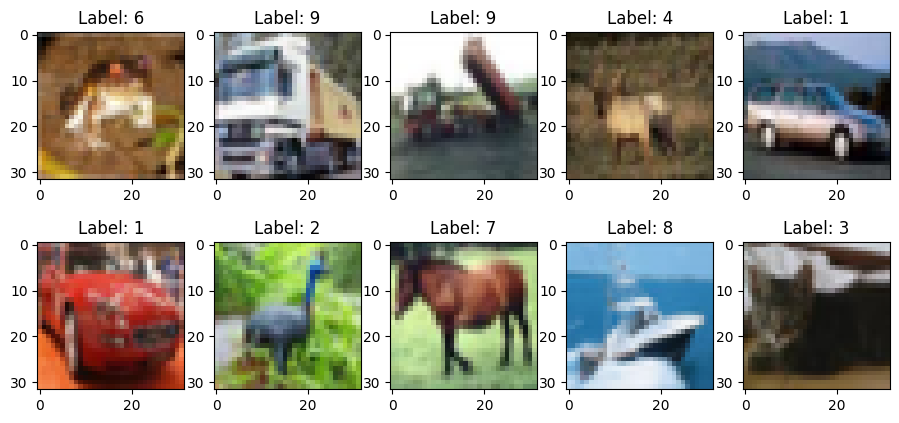

In [5]:
plt.figure(figsize = (11, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(f"Label: {y_train[i][0]}")

## Data exploration

CIFAR-10 is a well-established dataset for learning, so minimal cleaning or preprocessing is required. However, it will be verified that there are no empty or missing images in both the training and test sets, and also the class distribution will be checked.

* **Missing Images**

As expected, the dataset is clean and there are no missing images.

In [6]:
# Check for NaN values
np.isnan(x_train).any()
np.isnan(x_test).any()

np.False_

* **Class Distribution**

Examine the class distribution within the training set.

In [7]:
# Define the labels
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Text(0, 0.5, 'Count')

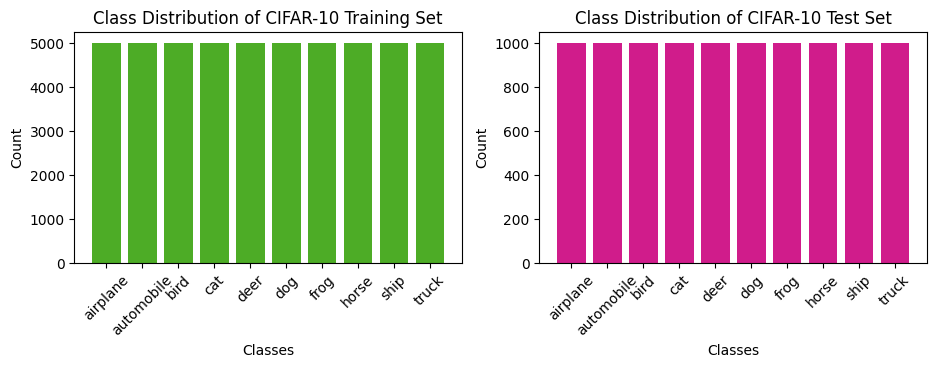

In [8]:
# Plot class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 3))

# Plot the class distribution for the training set
ax1.hist(y_train, bins = np.arange(11)-0.5, rwidth = 0.8, color = "#4dac26")
ax1.set_xticks(range(10))
ax1.set_xticklabels(classes, rotation = 45)
ax1.set_title("Class Distribution of CIFAR-10 Training Set")
ax1.set_xlabel("Classes")
ax1.set_ylabel("Count")

# Plot the class distribution for the test set
ax2.hist(y_test, bins = np.arange(11)-0.5, rwidth = 0.8, color = "#d01c8b")
ax2.set_xticks(range(10))
ax2.set_xticklabels(classes, rotation = 45)
ax2.set_title("Class Distribution of CIFAR-10 Test Set")
ax2.set_xlabel("Classes")
ax2.set_ylabel("Count")

As anticipated, the dataset is balanced, with each class containing the same number of instances. The training set includes 5.000 instances per class, and the test set contains 1.000 instances per class.

## Pre-processing

Data preprocessing is essential for improving model accuracy, efficiency, and generalization. The preprocessing methods used in this project to prepare the data for the model are: normalization and one-hot encoding.

* **Normalization**

Normalization is a key step in preprocessing, where the pixel values are scaled to an standard range. In this process, the pixel values of both the training and the test images are divided by 255.0, bringing them into a range between 0 and 1. This normalization step ensures the data is in an ideal format for the model, enhancing its ability to learn effectively.

In [9]:
# Normalize the pixel values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

* **One-hot encoding**

Categorical data can be tricky because machine learning models usually require numerical input, and categorical data doesn't have any inherent numerical relationships. One way to handle this is through one-hot encoding, which converts categorical labels into a binary format, making them easier for models to process. This technique is crucial because it transforms the data into a numerical format that the model can understand and use effectively.

In [10]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

The final step is to verify the shapes of the data after preprocessing to ensure that everything has been processed correctly.

In [11]:
print(f"Training data shape after preprocessing: {x_train.shape}")
print(f"Test data shape after preprocessing: {x_test.shape}")
print(f"Training labels shape after one-hot encoding: {y_train.shape}")
print(f"Test labels shape after one-hot encoding: {y_test.shape}")

Training data shape after preprocessing: (50000, 32, 32, 3)
Test data shape after preprocessing: (10000, 32, 32, 3)
Training labels shape after one-hot encoding: (50000, 10)
Test labels shape after one-hot encoding: (10000, 10)


## CNN Model

### **Architecture**

The CNN model architecture is inspired by VGG16, featuring multiple convolutional layers, max-pooling, dropout layers, and a fully connected layer for classification. The network begins with Conv2D layers (32 filters, 3x3), followed by Batch Normalization, MaxPooling2D, and Dropout layers to reduce overfitting. This pattern of Conv2D, Batch Normalization, MaxPooling2D, and Dropout is repeated three times, with the number of filters doubling at each repetition (32, 64, 128, 256), and the dropout rate increasing from 0.2 to 0.5. After the convolutional layers, the output is flattened and passed through a Dense layer with 10 units for classification, using softmax activation to convert the outputs to probability scores.

**CNN Architecture:**

1. **Input:** `32x32x3` (RGB image)

2. **Conv2D (32 filters, 3x3)**
   → **Activation:** ReLU
   → **BatchNormalization**
   → **MaxPooling2D (2x2)**
   → **Dropout (0.2)**
   → **Output shape:** `15x15x32`

3. **Conv2D (64 filters, 3x3)**
   → **Activation:** ReLU
   → **BatchNormalization**
   → **MaxPooling2D (2x2)**
   → **Dropout (0.3)**
   → **Output shape:** `6x6x64`

4. **Conv2D (128 filters, 3x3)**
   → **Activation:** ReLU
   → **BatchNormalization**
   → **MaxPooling2D (2x2)**
   → **Dropout (0.4)**
   → **Output shape:** `2x2x128`

5. **Conv2D (256 filters, 3x3)**
   → **Activation:** ReLU
   → **BatchNormalization**
   → **MaxPooling2D (2x2)**
   → **Dropout (0.5)**
   → **Output shape:** `1x1x256`

6. **Flatten**
   → **Output shape:** `256`

7. **Dense (256 units)**
   → **Activation:** ReLU
   → **Dropout (0.5)**
   → **Output shape:** `256`

8. **Dense (128 units)**
   → **Activation:** ReLU
   → **Dropout (0.5)**
   → **Output shape:** `128`

9. **Dense (10 units)**
   → **Activation:** Softmax
   → **Output shape:** `10` (class probabilities)

**Loss Function:** `categorical_crossentropy`

**Optimizer:** `Adam`

**Metric:** `accuracy`

In [12]:
# Define the model
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), padding="same", activation = "relu", input_shape = (32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), padding="same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), padding="same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

# Convolutional Block 4
model.add(Conv2D(256, (3, 3), padding="same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))

# Flatten the output
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(10, activation = "softmax"))

# Compile the model
model.compile(optimizer = Adam(),
              loss = CategoricalCrossentropy(label_smoothing = 0.1), # This reduces overconfidence and helps generalization
              metrics = ["accuracy"])

# Display model summary
model.summary()

c:\Users\Virginia\Python\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,922 (2.62 MB)

 Trainable params: 685,962 (2.62 MB)

 Non-trainable params: 960 (3.75 KB)

### **Callbacks**

Callbacks are tools used during the training process of the moel to monitor or change behaviour at specific points like at the end of each epoch. They can be used to stop training early, save models, adjust learning rates, among others.

In this project, the following callbacks will be used:

- **ReduceLROnPlateau**: If the validation loss doesn’t improve for 10 consecutive epochs, the learning rate will be reduced by half. This helps fine-tune the training process when progress slows.

- **EarlyStopping**: Training will stop if the validation loss doesn’t improve for 40 epochs, and it will automatically restore the model weights from the best-performing epoch.

- **ModelCheckpoint**: Saves the model’s weights to a file whenever it achieves a new best validation loss. This ensures the best version of the model is always saved during training.

In [13]:
# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, min_lr = 0.000001, verbose = 1)

# Stop earlier
early_stopping = EarlyStopping(monitor = "val_loss", patience = 15, restore_best_weights = True, verbose = 1)

# Save the best model
model_checkpoint = ModelCheckpoint(
    "../model/cnn-cifar10-model.keras",
    monitor = "val_accuracy",
    save_best_only = True,
    mode = "max",
    verbose = 1
)

### **Training**

After setting up the model architecture and configuring the callbacks, the next step is to train the model using the training dataset.

In [14]:
# Train the model with callbacks
history = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    batch_size = 64,
    epochs = 100,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    shuffle = True
)

Epoch 1/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1787 - loss: 2.4638
Epoch 1: val_accuracy improved from -inf to 0.34610, saving model to ../model/cnn-cifar10-model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 82ms/step - accuracy: 0.1788 - loss: 2.4630 - val_accuracy: 0.3461 - val_loss: 1.8403 - learning_rate: 0.0010
Epoch 2/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3479 - loss: 1.8782
Epoch 2: val_accuracy improved from 0.34610 to 0.44440, saving model to ../model/cnn-cifar10-model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - accuracy: 0.3479 - loss: 1.8781 - val_accuracy: 0.4444 - val_loss: 1.7091 - learning_rate: 0.0010
Epoch 3/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4262 - loss: 1.7388
Epoch 3: val_accuracy improved from 0.44440 to 0.51420, saving model to ../model/cnn-cifar10-model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - accuracy: 0.4262 - loss: 1.7387 - val_accuracy: 0.5142 - val_loss: 1.5657 - learning_rate: 0.

## Model Evaluation

Model evaluation helps assess how well the trained model performs on unseen data. It gives insights into the model’s generalization ability and whether it's overfitting or underfitting.

**Summary of the Evaluation:**

* **Best Validation Accuracy:** Reached at epoch 58, with approximately 0.8189 accuracy.
* **Training Trend:** Training accuracy steadily increased, and loss decreased—indicating effective learning.
* **Validation Trend:** Validation accuracy plateaued and fluctuated slightly after epoch 58, suggesting the model may have reached its optimal capacity.
* **Early Stopping:** Triggered at epoch 67, with model weights restored from the best epoch to avoid overfitting.

| Metric                   | Value / Observation          |
| ------------------------ | ---------------------------- |
| Best Epoch               | **58**                       |
| Best Validation Accuracy | **81.89%**                   |
| Final Training Accuracy  | \~81.7%                      |
| Overfitting Signs        | No sign of overfitting       |
| Underfitting Possibility | Slight signs of underfitting |
| Learning Rate Range      | `2.0e-4` → `1.56e-5`         |

In [15]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose = 1)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8185 - loss: 0.9233

Test loss: 0.9231
Test accuracy: 0.8173


## Model Visualization

Visualizing the model's training process helps make sense of how well it's learning and where it might be struggling. It gives a clearer picture of performance beyond just numbers. The graphs used to visualize the performance of the model are: training accuracy and loss, validation accuracy and loss, and confusion matrix.

**Summary of the Visualization:**

* **Training Accuracy & Loss:** Accuracy steadily improved and loss decreased over time, showing the model was learning effectively.
* **Validation Accuracy & Loss:** Validation accuracy peaked around epoch 68, with some fluctuations afterward—suggesting the model reached its peak performance around that point.
* **Confusion Matrix:** Gave a clear snapshot of how well the model classified each category, making it easy to spot which classes were predicted accurately and where it made mistakes.


**Training and validation accuracy and loss**

- **Training Accuracy & Loss:** Accuracy steadily improved and loss decreased over time, showing the model was learning effectively.
- **Validation Accuracy & Loss:** Validation accuracy peaked around epoch 68, with some fluctuations afterward—suggesting the model reached its peak performance around that point.

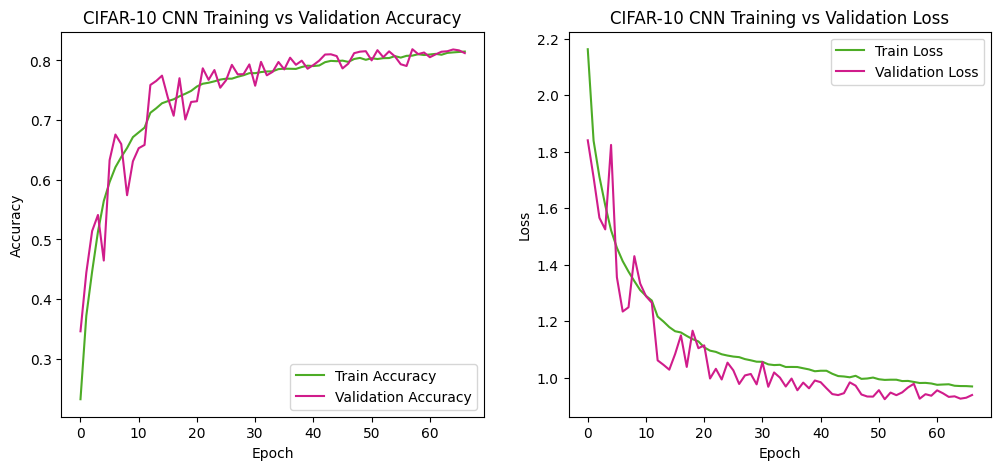

In [16]:
# Plot training & validation accuracy
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label = "Train Accuracy", color = "#4dac26")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy", color = "#d01c8b")
plt.title("CIFAR-10 CNN Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label = "Train Loss", color = "#4dac26")
plt.plot(history.history["val_loss"], label = "Validation Loss", color = "#d01c8b")
plt.title("CIFAR-10 CNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

**Confusion Matrix**

The confusion matrix offers a clear overview of how well the model classifies each category, making it easy to spot which classes were predicted accurately and where it made mistakes.

In [17]:
# Predict the values from the validation dataset
y_pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [18]:
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 

In [19]:
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

In [20]:
# Confussion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

Text(0.5, 1.0, 'Confusion Matrix of CIFAR-10 CNN Model')

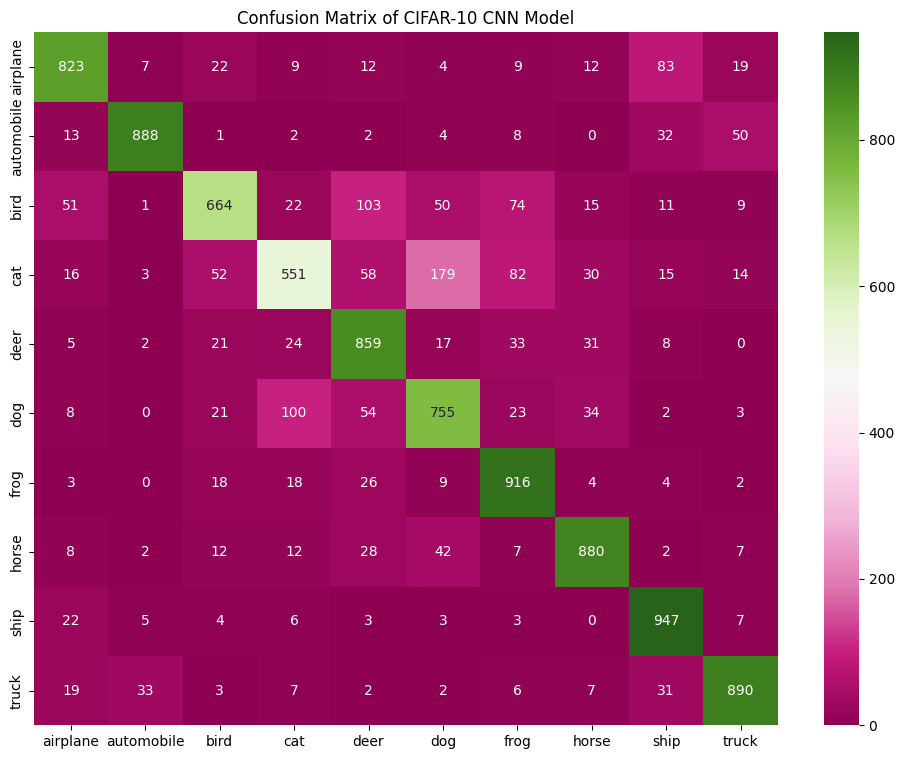

In [21]:
# Plot the confusion matrix
plt.figure(figsize = (12, 9))
c = sns.heatmap(confusion_mtx, annot = True, fmt = "g", cmap = "PiYG") #PiYG #PRGn
c.set(xticklabels = classes, yticklabels = classes)
plt.title("Confusion Matrix of CIFAR-10 CNN Model")

## Conclusions

This project involved the development and evaluation of a Convolutional Neural Network (CNN) for image classification using the CIFAR-10 dataset. The model achieved a best validation accuracy of **81.89%** at epoch 58, demonstrating effective learning and generalization capabilities.

Throughout training, accuracy increased steadily while loss decreased, indicating that the model was learning appropriately. Validation accuracy plateaued and fluctuated slightly after epoch 58, suggesting that the model had reached its optimal performance. Early stopping was triggered at epoch 67, with the model weights restored from the best-performing epoch to prevent overfitting. No clear signs of overfitting were observed, though slight underfitting may be present, potentially due to limitations in model capacity.

The final training accuracy (\~81.6%) was closely aligned with the validation and test accuracy, supporting the model’s generalization to unseen data. The learning rate was gradually reduced over the course of training—from `2.0e-4` to `1.56e-5`—contributing to model stability.

Overall, the CNN classifier performed well on the CIFAR-10 dataset. Future improvements may include experimenting with deeper or more advanced architectures, implementing data augmentation techniques, or further tuning hyperparameters to enhance performance.